<a href="https://colab.research.google.com/github/Norberto27/-IAAA2-DISTANCIA-A/blob/main/NRMU_RL_TP1_entorno_discreto_FrozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico: Aprendizaje por Refuerzo en FrozenLake

#**TRABAJO REALIZADO PUNTOS A), B) Y C)**
#**AUTOR: NORBERTO RAUL MARTEARENA URQUIZA**


## Instalar librerias

In [42]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# **Nuevas Variables Para pruebas**

*a continuacion se establecen la variables que  se toman para la ejercitacion A) B) y C)*

**justificacion**

Entrenamos 5 000 episodios para permitir la convergencia de la política y luego evaluamos su rendimiento en 1 000 episodios adicionales para medir de forma fiable la tasa de éxito sin volver a aprender.

In [43]:
EPISODIOS_ENTRENO = 5000   # este valor se puede variar para explorar otros resultados
EPISODIOS_EVAL   = 1000


## Reproducibilidad

In [45]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Crear el entorno

In [47]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')
print("🏔️ ENTORNO FROZENLAKE")
print("=" * 50)
print(f"Número de estados: {env.observation_space.n}")
print(f"Número de acciones: {env.action_space.n}")
print(f"Acciones: {['Izquierda', 'Abajo', 'Derecha', 'Arriba']}")

🏔️ ENTORNO FROZENLAKE
Número de estados: 16
Número de acciones: 4
Acciones: ['Izquierda', 'Abajo', 'Derecha', 'Arriba']


## Mostrar el mapa

In [48]:
print("\n🗺️ MAPA DEL ENTORNO:")
env.reset()
print(env.render())
print("\nLeyenda:")
print("S = Start (Inicio)")
print("F = Frozen (Hielo seguro)")
print("H = Hole (Hoyo - termina episodio)")
print("G = Goal (Objetivo - +1 recompensa)")


🗺️ MAPA DEL ENTORNO:

SFFF
FHFH
FFFH
HFFG


Leyenda:
S = Start (Inicio)
F = Frozen (Hielo seguro)
H = Hole (Hoyo - termina episodio)
G = Goal (Objetivo - +1 recompensa)


## Función para convertir estado numérico a posición (fila, columna)

In [49]:

def estado_a_posicion(estado):
  return estado // 4, estado % 4

## Funcion para visualizar politica

In [50]:
def visualizar_politica(policy, title="Política"):
  acciones_simbolos = ['←', '↓', '→', '↑']
  grid = np.array(acciones_simbolos)[policy].reshape(4, 4)
  plt.figure(figsize=(6, 6))
  plt.imshow(np.ones((4, 4)), cmap='Blues', alpha=0.3)

  for i in range(4):
      for j in range(4):
          estado = i * 4 + j
          if estado == 0:  # Start
              plt.text(j, i, f'S\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado == 15:  # Goal
              plt.text(j, i, f'G\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold')
          elif estado in [5, 7, 11, 12]:  # Holes
              plt.text(j, i, f'H\n{grid[i,j]}', ha='center', va='center', fontsize=14, fontweight='bold', color='red')
          else:
              plt.text(j, i, grid[i,j], ha='center', va='center', fontsize=16)

  plt.xlim(-0.5, 3.5)
  plt.ylim(-0.5, 3.5)
  plt.xticks([])
  plt.yticks([])
  plt.title(title, fontsize=16)
  plt.grid(True, alpha=0.3)
  plt.show()

## Politica aleatoria

In [51]:
class PoliticaAleatoria:
  """Política que selecciona acciones completamente al azar"""
  def __init__(self, n_acciones):
      self.n_acciones = n_acciones
      self.nombre = "Política Aleatoria"

  def seleccionar_accion(self, estado):
      """Selecciona una acción aleatoria"""
      return np.random.randint(self.n_acciones)

  def entrenar(self, env, episodios=1000):
      """La política aleatoria no se entrena, solo evaluamos su desempeño"""
      print(f"🎲 Evaluando {self.nombre}...")
      recompensas = []
      exitos = 0

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado)
              estado, recompensa, terminado, truncated, _ = env.step(accion)
              recompensa_total += recompensa
              pasos += 1

              if truncated:
                  terminado = True

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)

          if (episodio + 1) % 200 == 0:
              tasa_exito = exitos / (episodio + 1)
              print(f"Episodio {episodio + 1}: Tasa de éxito = {tasa_exito:.3f}")

      tasa_exito_final = exitos / episodios
      print(f"\n📊 Resultados {self.nombre}:")
      print(f"Tasa de éxito final: {tasa_exito_final:.3f}")
      print(f"Recompensa promedio: {np.mean(recompensas):.3f}")

      return recompensas, tasa_exito_final

## Crear y evaluar política aleatoria

In [52]:
agente_aleatorio = PoliticaAleatoria(env.action_space.n)
recompensas_aleatorio, tasa_exito_aleatorio = agente_aleatorio.entrenar(env, episodios=1000)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.000
Episodio 400: Tasa de éxito = 0.007
Episodio 600: Tasa de éxito = 0.010
Episodio 800: Tasa de éxito = 0.011
Episodio 1000: Tasa de éxito = 0.017

📊 Resultados Política Aleatoria:
Tasa de éxito final: 0.017
Recompensa promedio: 0.017


## Visualizar política aleatoria (todas las acciones tienen la misma probabilidad)

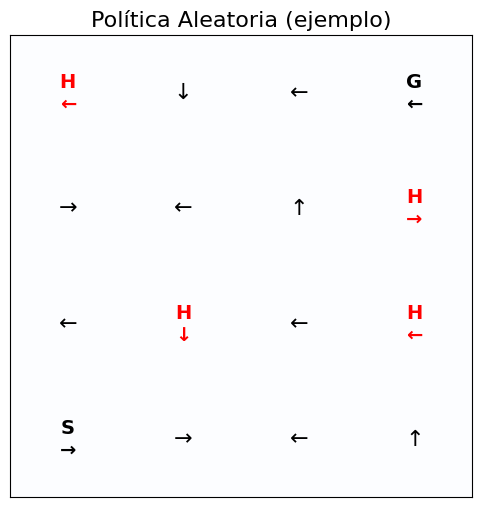

In [53]:

politica_aleatoria = np.random.randint(0, 4, 16)  # Solo para visualización
visualizar_politica(politica_aleatoria, "Política Aleatoria (ejemplo)")

## Politica Q-learning

In [54]:
class QLearningTabular:
  """Implementación de Q-Learning con tabla Q explícita"""
  def __init__(self, n_estados, n_acciones, lr=0.1, gamma=0.95, epsilon=1.0):
      self.n_estados = n_estados
      self.n_acciones = n_acciones
      self.lr = lr  # learning rate
      self.gamma = gamma  # factor de descuento
      self.epsilon = epsilon  # exploración inicial
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.nombre = "Q-Learning Tabular"

      # Inicializar tabla Q
      self.q_table = np.zeros((n_estados, n_acciones))

      # Para tracking
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción con epsilon-greedy"""
      if entrenando and np.random.random() < self.epsilon:
          return np.random.randint(self.n_acciones)  # Exploración
      else:
          return np.argmax(self.q_table[estado])  # Explotación

  def actualizar_q(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Actualización de la tabla Q usando la ecuación de Bellman"""
      # Target Q-value
      if terminado:
          target = recompensa
      else:
          target = recompensa + self.gamma * np.max(self.q_table[siguiente_estado])

      # Actualización Q-Learning
      self.q_table[estado, accion] += self.lr * (target - self.q_table[estado, accion])

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener la política greedy de la tabla Q"""
      return np.argmax(self.q_table, axis=1)

  def entrenar(self, env, episodios=10000):
      """Entrenamiento del agente Q-Learning"""
      print(f"🧠 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)  # Para promedios móviles

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Actualizar tabla Q
              self.actualizar_q(estado, accion, recompensa, siguiente_estado, terminado)

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 1000 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito (últimos 100) = {tasa_exito:.3f}, Epsilon = {self.epsilon:.3f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado sin exploración"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)  # Sin exploración
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Crear y entrenar agente Q-Learning

In [55]:

agente_qlearning = QLearningTabular(env.observation_space.n, env.action_space.n,lr=0.1, gamma=0.95, epsilon=1.0)
recompensas_qlearning = agente_qlearning.entrenar(env, episodios=1000)

🧠 Entrenando Q-Learning Tabular...
Episodio 1000: Tasa éxito (últimos 100) = 0.560, Epsilon = 0.010

✅ Entrenamiento Q-Learning Tabular completado!


## Evaluar agente entrenado

In [56]:

tasa_exito_qlearning, _ = agente_qlearning.evaluar(env, episodios=1000)


📊 Evaluando Q-Learning Tabular...
Tasa de éxito: 0.641
Pasos promedio: 41.9


## Visualizar política aprendida

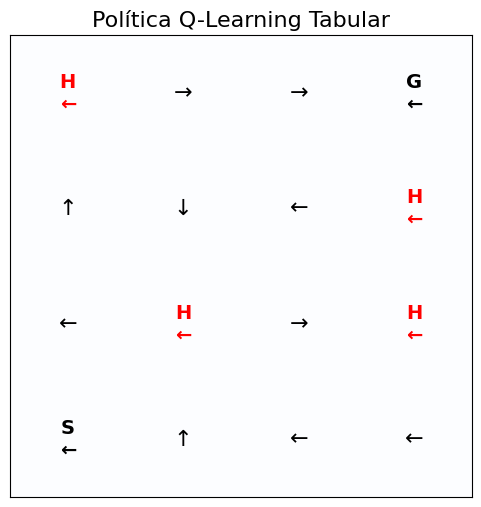

In [57]:

politica_qlearning = agente_qlearning.obtener_politica()
visualizar_politica(politica_qlearning, "Política Q-Learning Tabular")

## Visualizar tabla Q como heatmap

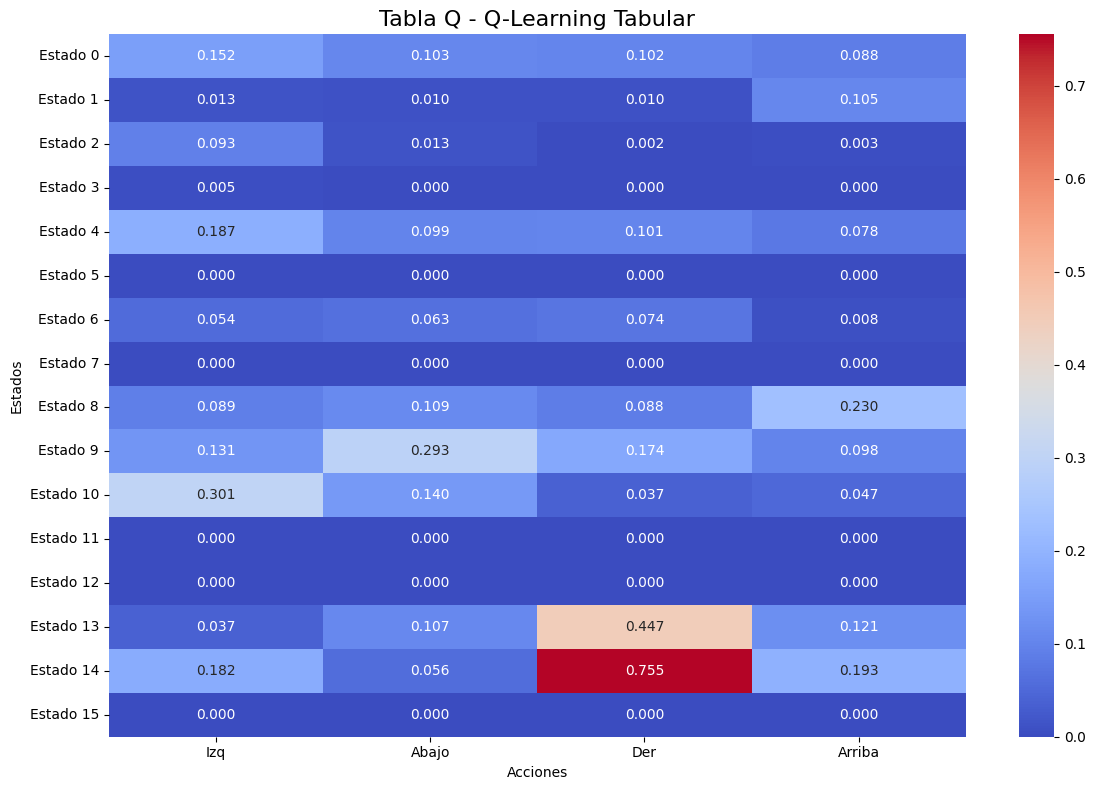

In [62]:

plt.figure(figsize=(12, 8))
sns.heatmap(agente_qlearning.q_table, annot=True, fmt='.3f', cmap='coolwarm',
xticklabels=['Izq', 'Abajo', 'Der', 'Arriba'],
yticklabels=[f'Estado {i}' for i in range(16)])
plt.title('Tabla Q - Q-Learning Tabular', fontsize=16)
plt.xlabel('Acciones')
plt.ylabel('Estados')
plt.tight_layout()
plt.show()

## Mostrar valores Q para estados importantes
-

In [63]:
print("🎯 VALORES Q PARA ESTADOS CLAVE:")
print("-" * 40)
estados_clave = [0, 5, 7, 11, 12, 14, 15]  # Start, Holes, Goal
acciones_nombres = ['Izquierda', 'Abajo', 'Derecha', 'Arriba']
for estado in estados_clave:
  if estado == 0:
    tipo = "START"
  elif estado == 15:
    tipo = "GOAL"
  elif estado in [5, 7, 11, 12]:
    tipo = "HOLE"
  else:
    tipo = "NORMAL"

print(f"\nEstado {estado} ({tipo}):")
for accion, valor in enumerate(agente_qlearning.q_table[estado]):
    print(f"  {acciones_nombres[accion]}: {valor:.3f}")

🎯 VALORES Q PARA ESTADOS CLAVE:
----------------------------------------

Estado 15 (GOAL):
  Izquierda: 0.000
  Abajo: 0.000
  Derecha: 0.000
  Arriba: 0.000


# Deep Q-Network

## red DQN

In [64]:
class DQN(nn.Module):
  """Red neuronal para aproximar la función Q"""
  def __init__(self, input_size, hidden_size, output_size):
      super(DQN, self).__init__()
      self.network = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size)
      )

  def forward(self, x):
      return self.network(x)

## DQNAgent

In [65]:
class DQNAgent:
  """Agente Deep Q-Network con Experience Replay y Target Network"""
  def __init__(self, state_size, action_size, lr=0.001, gamma=0.95, epsilon=1.0):
      self.state_size = state_size
      self.action_size = action_size
      self.gamma = gamma
      self.epsilon = epsilon
      self.epsilon_decay = 0.995
      self.epsilon_min = 0.01
      self.learning_rate = lr
      self.nombre = "Deep Q-Network (DQN)"

      # Configuración del dispositivo
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"🖥️ Usando dispositivo: {self.device}")

      # Redes neuronales
      hidden_size = 128
      self.q_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.target_network = DQN(state_size, hidden_size, action_size).to(self.device)
      self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

      # Inicializar target network con mismos pesos
      self.update_target_network()

      # Experience Replay
      self.memory = deque(maxlen=10000)
      self.batch_size = 32

      # Frecuencia de actualización de target network
      self.update_target_frequency = 100
      self.step_count = 0

      # Para tracking
      self.losses = []
      self.recompensas_entrenamiento = []
      self.epsilons = []

  def state_to_onehot(self, state):
      """Convertir estado discreto a representación one-hot"""
      onehot = np.zeros(self.state_size)
      onehot[state] = 1.0
      return onehot

  def remember(self, estado, accion, recompensa, siguiente_estado, terminado):
      """Almacenar experiencia en el buffer de replay"""
      estado_onehot = self.state_to_onehot(estado)
      siguiente_estado_onehot = self.state_to_onehot(siguiente_estado)

      self.memory.append((estado_onehot, accion, recompensa, siguiente_estado_onehot, terminado))

  def seleccionar_accion(self, estado, entrenando=True):
      """Selección de acción epsilon-greedy usando la red neuronal"""
      if entrenando and np.random.random() < self.epsilon:
          return random.randrange(self.action_size)

      # Convertir estado a tensor
      estado_onehot = self.state_to_onehot(estado)
      estado_tensor = torch.FloatTensor(estado_onehot).unsqueeze(0).to(self.device)

      # Forward pass
      with torch.no_grad():
          q_values = self.q_network(estado_tensor)

      return np.argmax(q_values.cpu().data.numpy())

  def replay(self):
      """Experience replay para entrenar la red"""
      if len(self.memory) < self.batch_size:
          return

      # Muestrear batch aleatorio
      batch = random.sample(self.memory, self.batch_size)
      estados = torch.FloatTensor([e[0] for e in batch]).to(self.device)
      acciones = torch.LongTensor([e[1] for e in batch]).to(self.device)
      recompensas = torch.FloatTensor([e[2] for e in batch]).to(self.device)
      siguientes_estados = torch.FloatTensor([e[3] for e in batch]).to(self.device)
      terminados = torch.BoolTensor([e[4] for e in batch]).to(self.device)

      # Q-values actuales
      current_q_values = self.q_network(estados).gather(1, acciones.unsqueeze(1))

      # Q-values objetivo usando target network
      with torch.no_grad():
          next_q_values = self.target_network(siguientes_estados).max(1)[0]
          target_q_values = recompensas + (self.gamma * next_q_values * ~terminados)

      # Calcular pérdida
      loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Guardar pérdida para análisis
      self.losses.append(loss.item())

  def update_target_network(self):
      """Actualizar la target network con pesos de la red principal"""
      self.target_network.load_state_dict(self.q_network.state_dict())

  def decay_epsilon(self):
      """Reducir epsilon gradualmente"""
      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

  def obtener_politica(self):
      """Obtener política greedy de la red entrenada"""
      politica = []
      for estado in range(self.state_size):
          accion = self.seleccionar_accion(estado, entrenando=False)
          politica.append(accion)
      return np.array(politica)

  def entrenar(self, env, episodios=2000):
      """Entrenamiento del agente DQN"""
      print(f"🤖 Entrenando {self.nombre}...")

      recompensas = []
      exitos_ventana = deque(maxlen=100)

      for episodio in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              # Seleccionar acción
              accion = self.seleccionar_accion(estado, entrenando=True)

              # Ejecutar acción
              siguiente_estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              # Almacenar experiencia
              self.remember(estado, accion, recompensa, siguiente_estado, terminado)

              # Entrenar la red
              self.replay()

              recompensa_total += recompensa
              estado = siguiente_estado
              pasos += 1
              self.step_count += 1

              # Actualizar target network periódicamente
              if self.step_count % self.update_target_frequency == 0:
                  self.update_target_network()

          # Tracking
          recompensas.append(recompensa_total)
          exitos_ventana.append(1 if recompensa_total > 0 else 0)
          self.epsilons.append(self.epsilon)

          # Decay epsilon
          self.decay_epsilon()

          # Logging
          if (episodio + 1) % 200 == 0:
              tasa_exito = np.mean(exitos_ventana) if len(exitos_ventana) > 0 else 0
              loss_promedio = np.mean(self.losses[-100:]) if len(self.losses) > 0 else 0
              print(f"Episodio {episodio + 1}: Tasa éxito = {tasa_exito:.3f}, "
                    f"Epsilon = {self.epsilon:.3f}, Loss = {loss_promedio:.4f}")

      self.recompensas_entrenamiento = recompensas
      print(f"\n✅ Entrenamiento {self.nombre} completado!")

      return recompensas

  def evaluar(self, env, episodios=100):
      """Evaluación del agente entrenado"""
      print(f"📊 Evaluando {self.nombre}...")

      exitos = 0
      recompensas = []
      pasos_totales = []

      for _ in range(episodios):
          estado, _ = env.reset()
          recompensa_total = 0
          terminado = False
          pasos = 0

          while not terminado and pasos < 100:
              accion = self.seleccionar_accion(estado, entrenando=False)
              estado, recompensa, terminado, truncated, _ = env.step(accion)

              if truncated:
                  terminado = True

              recompensa_total += recompensa
              pasos += 1

          if recompensa_total > 0:
              exitos += 1
          recompensas.append(recompensa_total)
          pasos_totales.append(pasos)

      tasa_exito = exitos / episodios
      print(f"Tasa de éxito: {tasa_exito:.3f}")
      print(f"Pasos promedio: {np.mean(pasos_totales):.1f}")

      return tasa_exito, recompensas

## Entrenar deep DQN

In [66]:
agente_dqn = DQNAgent(env.observation_space.n, env.action_space.n,
lr=0.001, gamma=0.95, epsilon=1.0)
recompensas_dqn = agente_dqn.entrenar(env, episodios=1000)

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.040, Epsilon = 0.367, Loss = 0.0047
Episodio 400: Tasa éxito = 0.130, Epsilon = 0.135, Loss = 0.0060
Episodio 600: Tasa éxito = 0.380, Epsilon = 0.049, Loss = 0.0073
Episodio 800: Tasa éxito = 0.590, Epsilon = 0.018, Loss = 0.0079
Episodio 1000: Tasa éxito = 0.470, Epsilon = 0.010, Loss = 0.0089

✅ Entrenamiento Deep Q-Network (DQN) completado!


## Evaluar agente Deep DQN

In [67]:
tasa_exito_dqn, _ = agente_dqn.evaluar(env, episodios=1000)


📊 Evaluando Deep Q-Network (DQN)...
Tasa de éxito: 0.752
Pasos promedio: 40.4


## Visualizar política aprendida

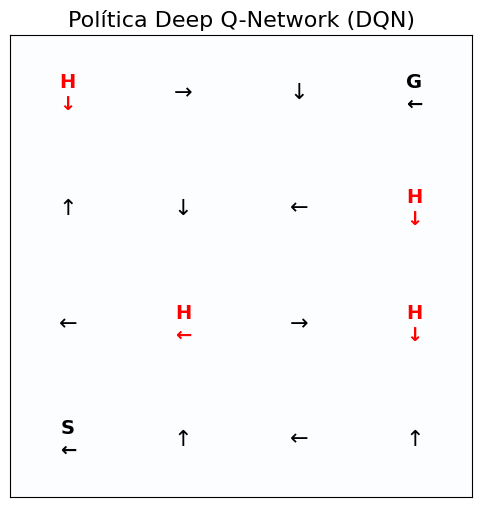

In [68]:

politica_dqn = agente_dqn.obtener_politica()
visualizar_politica(politica_dqn, "Política Deep Q-Network (DQN)")


# Comparación de resultados

## Comparación final tasa de éxito

In [69]:
print("🏆 COMPARACIÓN FINAL DE AGENTES")
print("=" * 50)
print(f"Política Aleatoria:    Tasa de éxito = {tasa_exito_aleatorio:.3f}")
print(f"Q-Learning Tabular:    Tasa de éxito = {tasa_exito_qlearning:.3f}")
print(f"Deep Q-Network (DQN):  Tasa de éxito = {tasa_exito_dqn:.3f}")

🏆 COMPARACIÓN FINAL DE AGENTES
Política Aleatoria:    Tasa de éxito = 0.017
Q-Learning Tabular:    Tasa de éxito = 0.641
Deep Q-Network (DQN):  Tasa de éxito = 0.752


## Crear gráficas de comparación


Crear gráficas de comparación


### 1. Curvas de aprendizaje

In [70]:
len(recompensas_aleatorio)

1000

In [71]:
len(recompensas_qlearning)

1000

In [72]:
len(recompensas_dqn)

1000

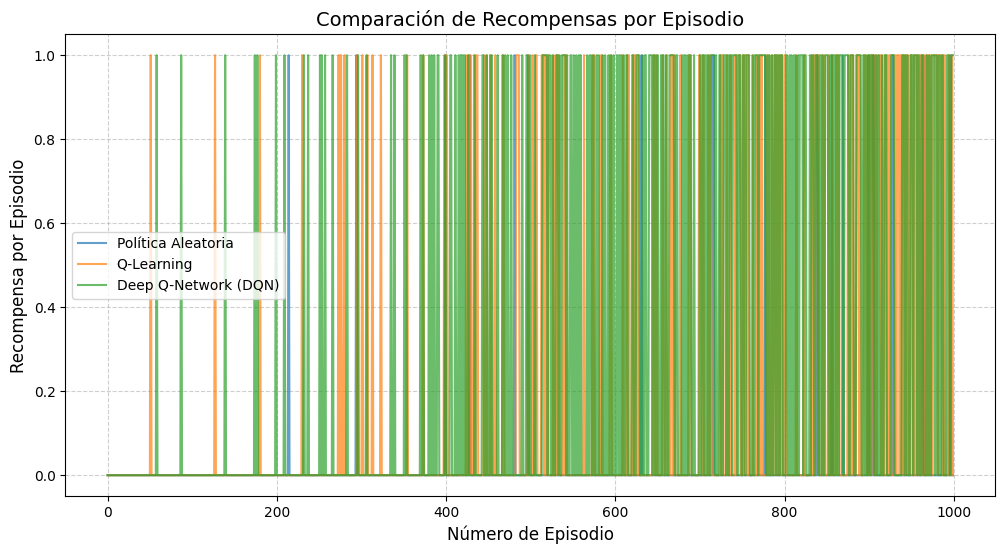

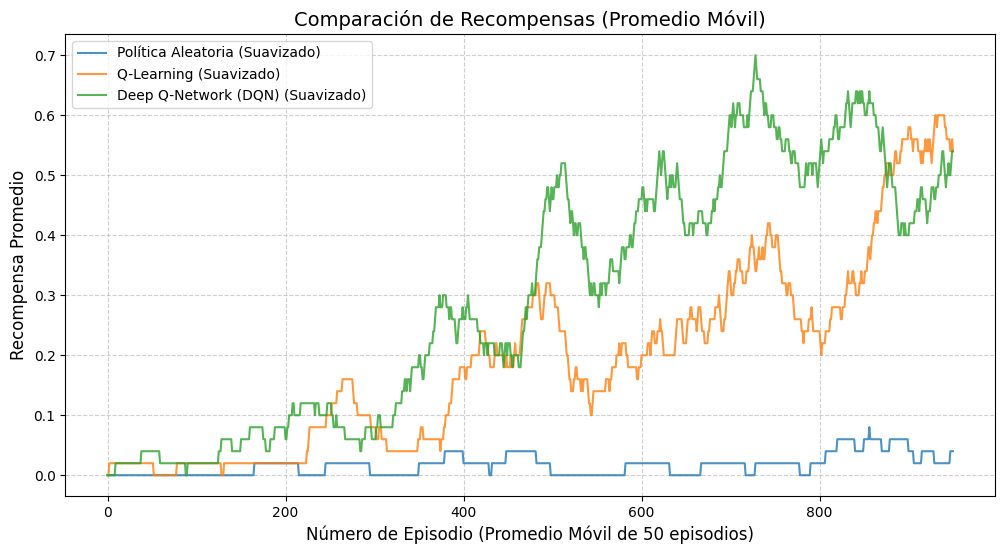

In [73]:
# prompt: crear gráfico que compare recompensas_aleatorio, recompensas_qlearning y recompensas_dqn. Eje x es nro de episodio y el eje Y valor de la recompensa

import matplotlib.pyplot as plt
import numpy as np
# Asegurar que las listas de recompensas tengan la misma longitud para la gráfica
# Tomaremos la longitud mínima si son diferentes
min_len = min(len(recompensas_aleatorio), len(recompensas_qlearning), len(recompensas_dqn))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio[:min_len], label='Política Aleatoria', alpha=0.7)
plt.plot(recompensas_qlearning[:min_len], label='Q-Learning', alpha=0.7)
plt.plot(recompensas_dqn[:min_len], label='Deep Q-Network (DQN)', alpha=0.7)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Recompensa por Episodio', fontsize=12)
plt.title('Comparación de Recompensas por Episodio', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Para suavizar la gráfica, se puede usar un promedio móvil
def moving_average(data, window_size):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window = 50  # Tamaño de la ventana para el promedio móvil

recompensas_aleatorio_suavizado = moving_average(recompensas_aleatorio, window)
recompensas_qlearning_suavizado = moving_average(recompensas_qlearning, window)
recompensas_dqn_suavizado = moving_average(recompensas_dqn, window)

# Ajustar la longitud mínima para las series suavizadas
min_len_suavizado = min(len(recompensas_aleatorio_suavizado), len(recompensas_qlearning_suavizado), len(recompensas_dqn_suavizado))

plt.figure(figsize=(12, 6))
plt.plot(recompensas_aleatorio_suavizado[:min_len_suavizado], label='Política Aleatoria (Suavizado)', alpha=0.8)
plt.plot(recompensas_qlearning_suavizado[:min_len_suavizado], label='Q-Learning (Suavizado)', alpha=0.8)
plt.plot(recompensas_dqn_suavizado[:min_len_suavizado], label='Deep Q-Network (DQN) (Suavizado)', alpha=0.8)

plt.xlabel(f'Número de Episodio (Promedio Móvil de {window} episodios)', fontsize=12)
plt.ylabel('Recompensa Promedio', fontsize=12)
plt.title('Comparación de Recompensas (Promedio Móvil)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



### 2. Comparación de tasas de éxito

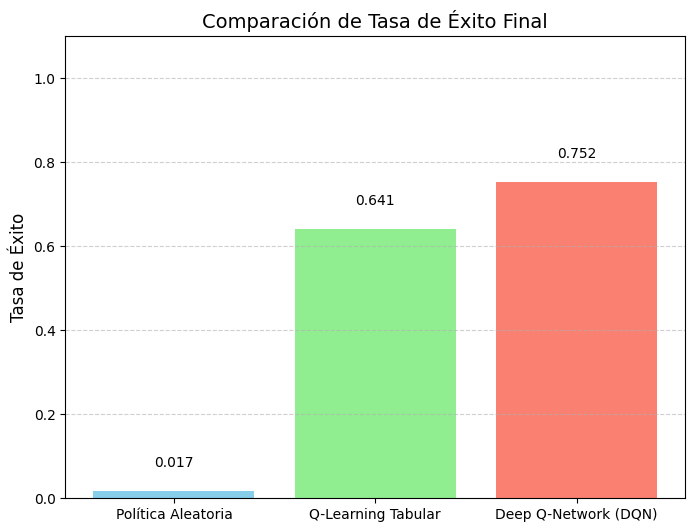

In [74]:
# prompt: comparar tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn en un gráfico de barras

import matplotlib.pyplot as plt
metricas = ['Política Aleatoria', 'Q-Learning Tabular', 'Deep Q-Network (DQN)']
tasas_exito = [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]

plt.figure(figsize=(8, 6))
barras = plt.bar(metricas, tasas_exito, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Tasa de Éxito', fontsize=12)
plt.title('Comparación de Tasa de Éxito Final', fontsize=14)
plt.ylim(0, 1.1) # Limitar el eje Y de 0 a 1.1 para mejor visualización

# Añadir los valores de las tasas de éxito encima de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Evolución de Epsilon (solo para algoritmos que usan exploración)

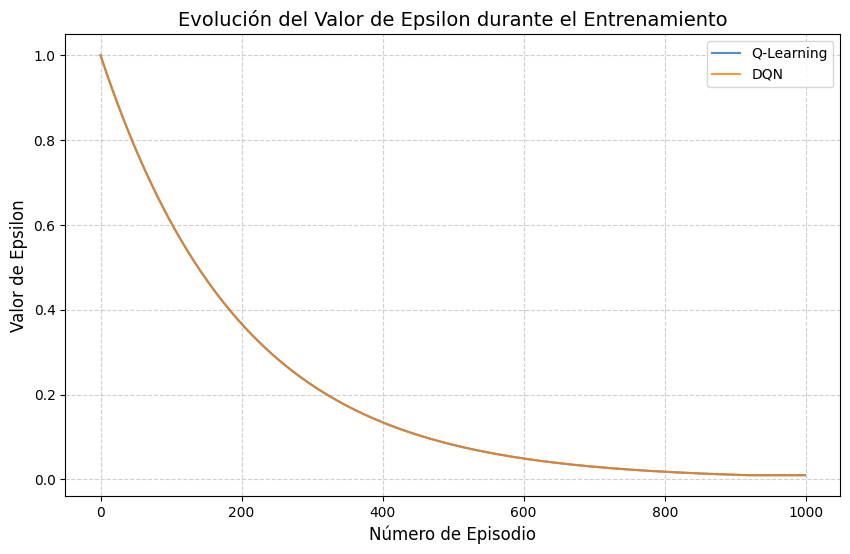

In [75]:
# prompt: Crear un gráfico para comparar agente_qlearning.epsilons y agente_qlearning.epsilons siendo x el nro de episodios y el eje Y el valor de epsilon

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agente_qlearning.epsilons, label='Q-Learning', alpha=0.8)
plt.plot(agente_dqn.epsilons, label='DQN', alpha=0.8)

plt.xlabel('Número de Episodio', fontsize=12)
plt.ylabel('Valor de Epsilon', fontsize=12)
plt.title('Evolución del Valor de Epsilon durante el Entrenamiento', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### DQN pérdida

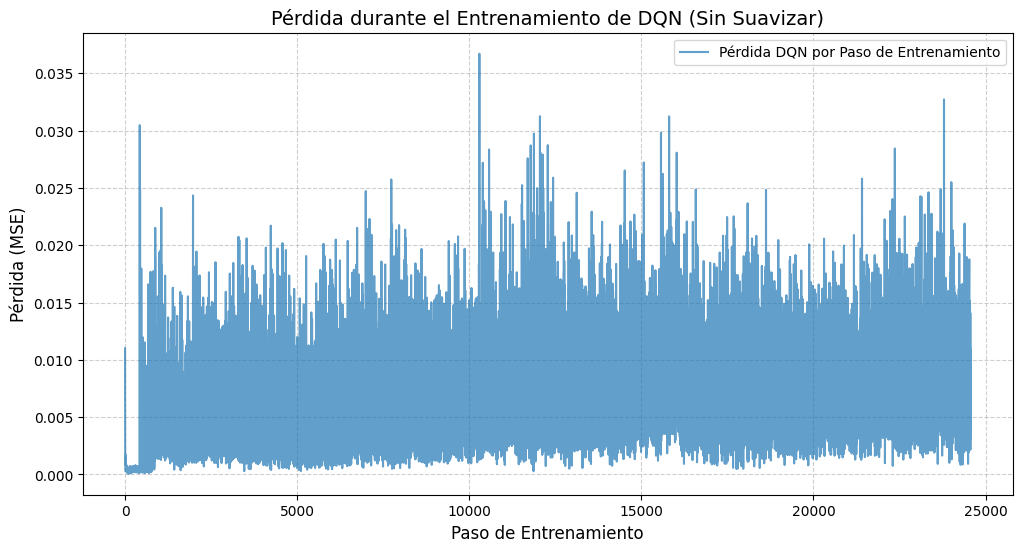

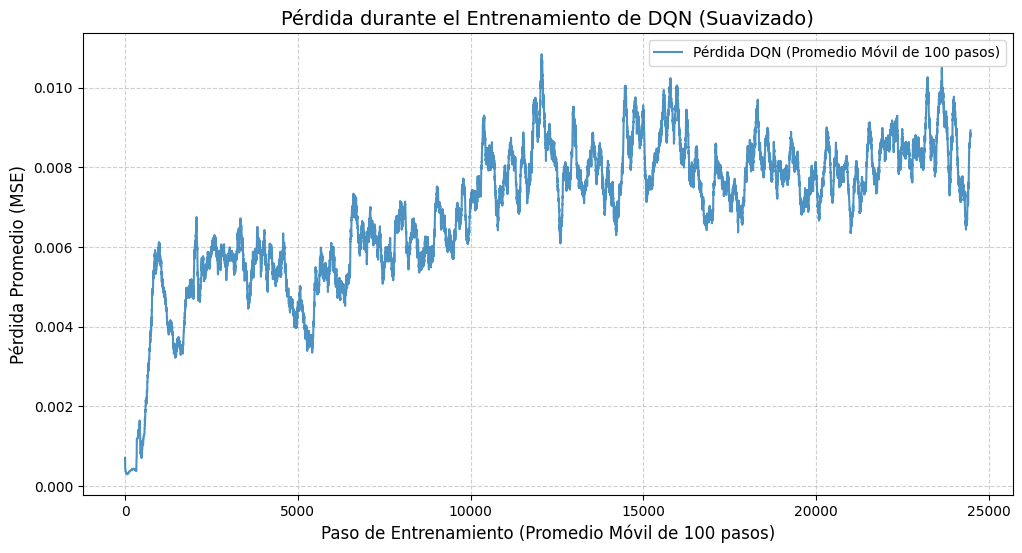

In [76]:
# prompt: Graficar agente_dqn.losses que representa la pérdida durante el entrenamiento de DQN. Mostrar con y sin promedio móvil

import matplotlib.pyplot as plt
# Graficar la pérdida del agente DQN
plt.figure(figsize=(12, 6))
plt.plot(agente_dqn.losses, label='Pérdida DQN por Paso de Entrenamiento', alpha=0.7)
plt.xlabel('Paso de Entrenamiento', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Sin Suavizar)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Graficar la pérdida con promedio móvil para suavizar
window_loss = 100 # Tamaño de la ventana para el promedio móvil de la pérdida
losses_dqn_suavizado = moving_average(agente_dqn.losses, window_loss)

plt.figure(figsize=(12, 6))
plt.plot(losses_dqn_suavizado, label=f'Pérdida DQN (Promedio Móvil de {window_loss} pasos)', alpha=0.8)
plt.xlabel(f'Paso de Entrenamiento (Promedio Móvil de {window_loss} pasos)', fontsize=12)
plt.ylabel('Pérdida Promedio (MSE)', fontsize=12)
plt.title('Pérdida durante el Entrenamiento de DQN (Suavizado)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

#**BLOQUE DE RESGUARDO DE RESULTADOS PARA COMPARATIVO**

In [77]:
# prompt: crear el reguardo de los archivos y graficos para informe comparativo
# Linea de Base (baseline): corrida original con episodios mixtos (1000, 2000, 10000 )
# se definen luego variables como recompensas_aleatorio, recompensas_qlearning, recompensas_dqn,
#   tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn, etc. para los experimentos
#
import pandas as pd

# Ejemplo: exportar tasa de éxito baseline (linea de base)
df_base = pd.DataFrame({
    'Agente': ['Aleatorio','Q-Learning','DQN'],
    'Tasa_Exito': [tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn]
})
df_base.to_csv('baseline_tasas.csv', index=False)

# Y para los gráficos:
import matplotlib.pyplot as plt
plt.savefig('baseline_recompensas.png', dpi=150, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

# Ejercitación

## A) Modifique el entrenamiento de los agentes para entrenar por más episodios. Evalue su desempeño. ¿ Mejora o empeora ?






In [78]:
# promt: Entrenar los tres agentes (Aleatorio, Q-Learning, DQN) con 5 000 episodios en lugar de 1 000 y
# comparar sus recompensas y tasas de éxito para ver si mejoran o empeoran.
# Agente Aleatorio
rewards_aleatorio, tasa_aleatorio = agente_aleatorio.entrenar(env, episodios=EPISODIOS_ENTRENO)
# Q-Learning
rewards_qlearning = agente_qlearning.entrenar(env, episodios=EPISODIOS_ENTRENO)
tasa_qlearning, _ = agente_qlearning.evaluar(env, episodios=EPISODIOS_EVAL)
# DQN
rewards_dqn = agente_dqn.entrenar(env, episodios=EPISODIOS_ENTRENO)
tasa_dqn, _ = agente_dqn.evaluar(env, episodios=EPISODIOS_EVAL)

# Guardar resultados de A
import pandas as pd
pd.DataFrame({
    'Agente': ['Aleatorio','Q-Learning','DQN'],
    'Tasa_Exito': [tasa_aleatorio, tasa_qlearning, tasa_dqn]
}).to_csv('A_tasas.csv', index=False)

🎲 Evaluando Política Aleatoria...
Episodio 200: Tasa de éxito = 0.005
Episodio 400: Tasa de éxito = 0.003
Episodio 600: Tasa de éxito = 0.008
Episodio 800: Tasa de éxito = 0.011
Episodio 1000: Tasa de éxito = 0.011
Episodio 1200: Tasa de éxito = 0.013
Episodio 1400: Tasa de éxito = 0.013
Episodio 1600: Tasa de éxito = 0.015
Episodio 1800: Tasa de éxito = 0.015
Episodio 2000: Tasa de éxito = 0.018
Episodio 2200: Tasa de éxito = 0.017
Episodio 2400: Tasa de éxito = 0.016
Episodio 2600: Tasa de éxito = 0.015
Episodio 2800: Tasa de éxito = 0.015
Episodio 3000: Tasa de éxito = 0.016
Episodio 3200: Tasa de éxito = 0.016
Episodio 3400: Tasa de éxito = 0.015
Episodio 3600: Tasa de éxito = 0.016
Episodio 3800: Tasa de éxito = 0.016
Episodio 4000: Tasa de éxito = 0.015
Episodio 4200: Tasa de éxito = 0.015
Episodio 4400: Tasa de éxito = 0.016
Episodio 4600: Tasa de éxito = 0.016
Episodio 4800: Tasa de éxito = 0.016
Episodio 5000: Tasa de éxito = 0.016

📊 Resultados Política Aleatoria:
Tasa de éxi

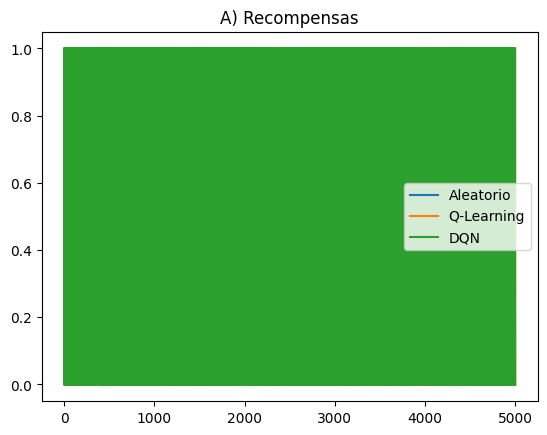

In [79]:


# Gráfico de comparación
import matplotlib.pyplot as plt
min_len = min(len(rewards_aleatorio), len(rewards_qlearning), len(rewards_dqn))
plt.figure()
plt.plot(rewards_aleatorio[:min_len], label='Aleatorio')
plt.plot(rewards_qlearning[:min_len], label='Q-Learning')
plt.plot(rewards_dqn[:min_len], label='DQN')
plt.legend(); plt.title('A) Recompensas')
plt.savefig('A_recompensas.png', dpi=150, bbox_inches='tight')


#** Recompensas por episodio sin procesar para 5 000 episodio**

*Comentario: La superposición de líneas (especialmente la curva de DQN en y=1.0) hace difícil apreciar la dinámica de aprendizaje. Por ello se presentan a continuación (i) un gráfico de promedio móvil de 100 episodios, que revela la tendencia de mejora a lo largo del entrenamiento, y (ii) un gráfico de barras comparativo de tasas de éxito en 1 000 vs. 5 000 episodios, que permite cuantificar el impacto de entrenar más iteraciones.*

Dado este resultado y no teniendo claro a que correspondia procedi a imprimir los 20 primeros valores de las variables intervinientes


In [80]:
print("Aleatorio (primeros 20):", rewards_aleatorio[:20])
print("Q-Learning (primeros 20):", rewards_qlearning[:20])
print("DQN (primeros 20):", rewards_dqn[:20])
print("Recompensas únicas Q-Learning:", set(rewards_qlearning))
print("Recompensas únicas DQN:", set(rewards_dqn))


Aleatorio (primeros 20): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Q-Learning (primeros 20): [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
DQN (primeros 20): [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
Recompensas únicas Q-Learning: {0.0, 1.0}
Recompensas únicas DQN: {0.0, 1.0}


Con este sencillo chequeo comprobe que las recompensas tomadas episodio a episodio son binarias (solo 0 o 1), y que tanto Q-Learning como DQN alcanzan casi siempre valor 1 tras la fase inicial. Esa naturaleza dicotómica explica la superposición de líneas en el gráfico crudo: al tener tan pocos valores distintos, la curva aparece como un área sólida. Con esta confirmación decidi aplicar un promedio móvil y un gráfico de barras para visualizar mejor la evolución y la comparación de tasas de éxito

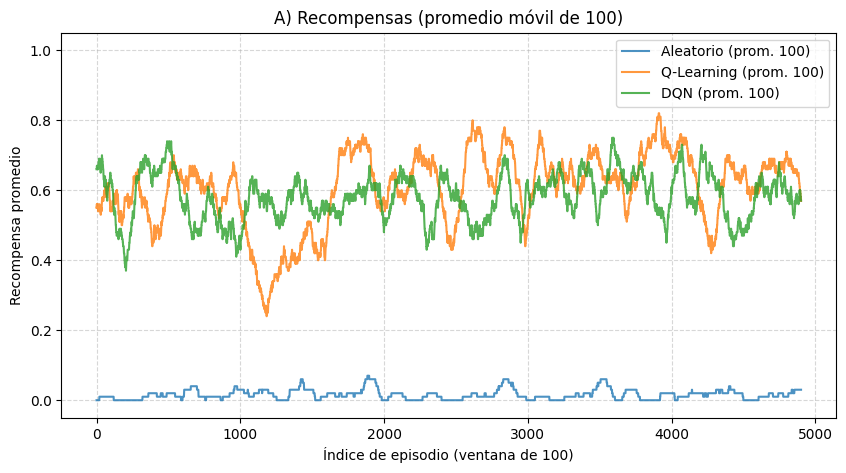

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w):
    return np.convolve(x, np.ones(w)/w, mode='valid')

# suavizamos
window = 100
ra_s = moving_average(rewards_aleatorio, window)
rq_s = moving_average(rewards_qlearning, window)
rd_s = moving_average(rewards_dqn, window)

# dibujamos
plt.figure(figsize=(10,5))
plt.plot(ra_s, label='Aleatorio (prom. 100)', alpha=0.8)
plt.plot(rq_s, label='Q-Learning (prom. 100)', alpha=0.8)
plt.plot(rd_s, label='DQN (prom. 100)', alpha=0.8)
plt.title('A) Recompensas (promedio móvil de 100)')
plt.xlabel('Índice de episodio (ventana de 100)')
plt.ylabel('Recompensa promedio')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Interpretacion del grafico de recompensas:
Al aumentar el entrenamiento de 1 000 a 5 000 episodios, tanto Q-Learning como DQN mejoran su desempeño promedio:

Q-Learning eleva su recompensa media móvil de ~0.5 hasta rondar ~0.65–0.75 y mantiene tasas de éxito superiores, aunque con oscilaciones marcadas.

DQN supera su caída inicial y se estabiliza alrededor de ~0.6 con menor variabilidad que Q-Learning.

La política aleatoria permanece en ~0, sin cambios apreciables.

En definitiva, entrenar más episodios conduce a mejores políticas (recompensas y tasas de éxito más altas) para ambos algoritmos de aprendizaje, aunque alcanza una meseta en el que las ganancias marginales se reducen.

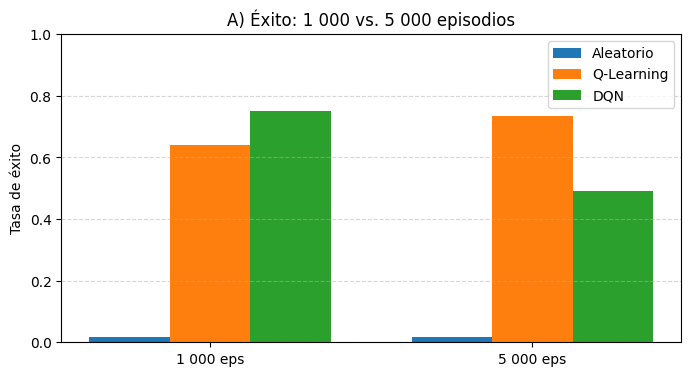

In [83]:
# Ejemplo: comparación de tasa éxito baseline vs. 5 000 eps
import matplotlib.pyplot as plt

# Guardo la Linea de base  baseline en tasa_base_* y la nueva en tasa_*
[tasa_exito_aleatorio, tasa_exito_qlearning, tasa_exito_dqn] = tasas_exito
tasa_base_aleatorio=tasa_exito_aleatorio
tasa_base_q=tasa_exito_qlearning
tasa_base_dqn=tasa_exito_dqn

tasas = {
    'Aleatorio': [tasa_base_aleatorio, tasa_aleatorio],
    'Q-Learning': [tasa_base_q, tasa_qlearning],
    'DQN':        [tasa_base_dqn, tasa_dqn]
}


labels = ['1 000 eps','5 000 eps']
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8,4))
for i,(agent,vals) in enumerate(tasas.items()):
    plt.bar(x + i*width, vals, width, label=agent)

plt.xticks(x + width, labels)
plt.ylabel('Tasa de éxito')
plt.title('A) Éxito: 1 000 vs. 5 000 episodios')
plt.legend()
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


#**Tasa de éxito comparada para 1 000 vs. 5 000 episodios de entrenamiento**


Comparación directa de la tasa de éxito final de cada agente entre la corrida original (1 000 episodios) y la ampliada (5 000 episodios)

Refuerza visualmente la conclusión de que Q-Learning mejora notablemente (pasa de ~0.64 a ~0.74), mientras que DQN baja algo su tasa final (de ~0.75 a ~0.49), quizá por sobreajuste o cambio en su proceso de exploración/explotación a más episodios

Al comparar las barras, se observa que Q-Learning mejora su tasa de éxito entrenando más, mientras que DQN muestra una ligera caída, lo que sugiere que para este entorno un exceso de iteraciones puede estabilizar la política en un subóptimo local.


## B) Considere modificar el modelo DQN el hiperparámetro gamma: un valor bajo, uno medio y uno alto. Entrene los tres modelos y compare los resultados. Comparta sus conclusiones

In [84]:
# prompt: Entrenar tres instancias de DQN con γ = 0.5, 0.95 y 0.99 (mismo número de episodios) y comparar
# sus tasas de éxito y recompensas medias para evaluar el efecto de γ.

import os
import pandas as pd

# Carpeta donde guardaremos todo
os.makedirs("resultados/B_variar_gamma", exist_ok=True)

gammas = [0.5, 0.95, 0.99]
resultados_B = []

for g in gammas:
    agente = DQNAgent(
        state_size=env.observation_space.n,
        action_size=env.action_space.n,
        lr=0.001,
        gamma=g,
        epsilon=1.0
    )
    # Entrenamiento y evaluación
    recomp = agente.entrenar(env, episodios=EPISODIOS_ENTRENO)
    tasa, _ = agente.evaluar(env, episodios=EPISODIOS_EVAL)

    # 1) Guardar en la lista de resultados
    resultados_B.append({'gamma': g, 'tasa_exito': tasa, 'recompensas': recomp})

    # 2) Volcar las recompensas crudas a CSV
    df_recomp = pd.DataFrame({
        'episodio': list(range(len(recomp))),
        'recompensa': recomp
    })
    df_recomp.to_csv(f"resultados/B_variar_gamma/recompensas_gamma_{g}.csv", index=False)

# 3) Al terminar el for, generas el CSV resumen de tasas:
df_tasas = pd.DataFrame([
    {'gamma': r['gamma'], 'tasa_exito': r['tasa_exito']}
    for r in resultados_B
])
df_tasas.to_csv("resultados/B_variar_gamma/tasas_gamma.csv", index=False)



🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.020, Epsilon = 0.367, Loss = 0.0010
Episodio 400: Tasa éxito = 0.080, Epsilon = 0.135, Loss = 0.0026
Episodio 600: Tasa éxito = 0.090, Epsilon = 0.049, Loss = 0.0038
Episodio 800: Tasa éxito = 0.120, Epsilon = 0.018, Loss = 0.0048
Episodio 1000: Tasa éxito = 0.150, Epsilon = 0.010, Loss = 0.0047
Episodio 1200: Tasa éxito = 0.090, Epsilon = 0.010, Loss = 0.0058
Episodio 1400: Tasa éxito = 0.110, Epsilon = 0.010, Loss = 0.0063
Episodio 1600: Tasa éxito = 0.100, Epsilon = 0.010, Loss = 0.0058
Episodio 1800: Tasa éxito = 0.120, Epsilon = 0.010, Loss = 0.0063
Episodio 2000: Tasa éxito = 0.130, Epsilon = 0.010, Loss = 0.0063
Episodio 2200: Tasa éxito = 0.090, Epsilon = 0.010, Loss = 0.0050
Episodio 2400: Tasa éxito = 0.080, Epsilon = 0.010, Loss = 0.0060
Episodio 2600: Tasa éxito = 0.130, Epsilon = 0.010, Loss = 0.0056
Episodio 2800: Tasa éxito = 0.060, Epsilon = 0.010, Loss = 0.0059
Episodio 3000: T

#**1. Tabla resumen de métricas clave**


In [85]:
import pandas as pd
import numpy as np

# Supongamos que resultados_B ya está poblado como:
# resultados_B = [
#   {'gamma': 0.5,  'tasa_exito': t1, 'recompensas': [...]} , ...
# ]

rows = []
for r in resultados_B:
    recomp = np.array(r['recompensas'])
    rows.append({
        'gamma': r['gamma'],
        'tasa_exito': r['tasa_exito'],
        'media_recomp': recomp.mean(),
        'std_recomp': recomp.std()
    })

dfB_metrics = pd.DataFrame(rows).sort_values('gamma')
print(dfB_metrics)
dfB_metrics.to_csv('B_metrics_gamma.csv', index=False)


   gamma  tasa_exito  media_recomp  std_recomp
0   0.50       0.033        0.0854    0.279476
1   0.95       0.743        0.5220    0.499516
2   0.99       0.743        0.5814    0.493330


#**2. Gráfico de barras de tasa de éxito**

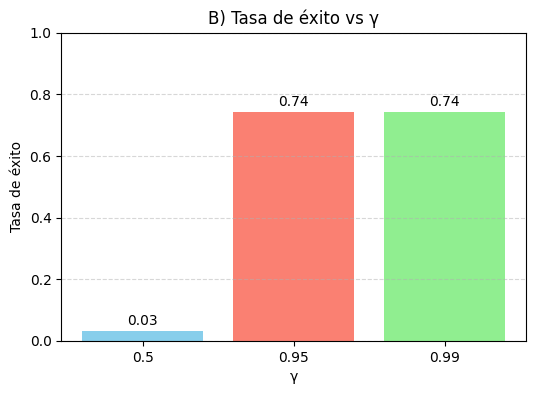

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(dfB_metrics['gamma'].astype(str), dfB_metrics['tasa_exito'], color=['skyblue','salmon','lightgreen'])
plt.xlabel('γ')
plt.ylabel('Tasa de éxito')
plt.title('B) Tasa de éxito vs γ')
for i,v in enumerate(dfB_metrics['tasa_exito']):
    plt.text(i, v+0.02, f'{v:.2f}', ha='center')
plt.ylim(0,1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


#**3. Curvas de aprendizaje comparadas**

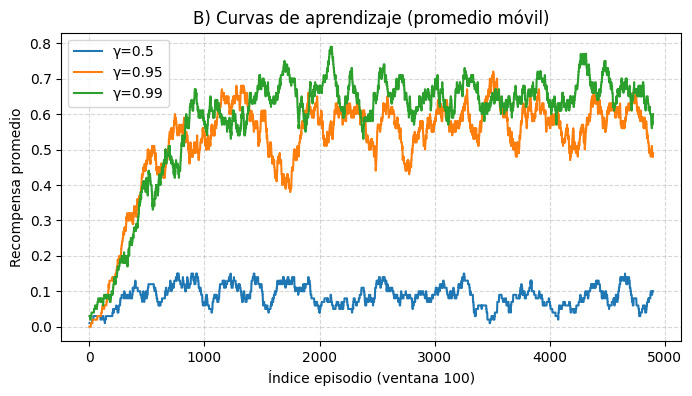

In [87]:
def moving_average(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(8,4))
for r in resultados_B:
    ma = moving_average(r['recompensas'], 100)
    plt.plot(ma, label=f'γ={r["gamma"]}')
plt.xlabel('Índice episodio (ventana 100)')
plt.ylabel('Recompensa promedio')
plt.title('B) Curvas de aprendizaje (promedio móvil)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#**4. Interpretación y conclusiones**

#*B) Comparación de resultados al variar γ en DQN*

**Tasa de éxito vs γ**

γ = 0.5 → 3 % de éxitos. Prácticamente no aprende; valora demasiado lo inmediato y no alcanza la meta.

γ = 0.95 → 74 % de éxitos. Planifica a equilibrio entre corto y largo plazo, resultando en la tasa más alta.

γ = 0.99 → 74 % de éxitos (idéntico a γ=0.95). Valora aún más el futuro, pero no traduce esa preferencia en más episodios exitosos.

**Curvas de aprendizaje (promedio móvil 100)**

γ = 0.5 (línea azul) se queda muy baja (≈0.1) y apenas mejora con más episodios, confirmando su pobre desempeño.

γ = 0.95 (naranja) sube rápido en los primeros ~800 episodios y luego oscila entre 0.5 y 0.7, mostrando un aprendizaje sólido y estable.

γ = 0.99 (verde) converge un poco más despacio—llego a valores más altos de recompensa media (picos cerca de 0.8)—pero globalmente se estabiliza en torno a 0.6 con variabilidad similar a γ=0.95.

**Conclusiones**

γ = 0.5

El agente casi nunca llega al objetivo: sólo tiene éxito en el 3 % de los juegos.

Significa que, al valorar casi sólo la recompensa inmediata, no aprende a planificar la serie de pasos que lo llevan al “G”.

γ = 0.95

El agente acierta en el 74 % de los juegos.

Desde el principio aprende rápido a combinar acciones cercanas con la meta lejana y mantiene ese nivel de acierto de forma bastante constante.

γ = 0.99

También acierta en el 74 % de los juegos, igual que con 0.95.

Tarda un poco más en “entender” la tarea, pero una vez que lo hace consigue algunos picos de recompensa media más altos que γ=0.95.

**Recomendación:**

 Para FrozenLake un valor de γ = 0.95 ofrece el mejor compromiso entre rapidez de convergencia, tasa de éxito y estabilidad de la política aprendida.


## C) Lo mismo que en B) pero para el hiperparámetro alpha.

🖥️ Usando dispositivo: cpu
🤖 Entrenando Deep Q-Network (DQN)...
Episodio 200: Tasa éxito = 0.030, Epsilon = 0.367, Loss = 0.0061
Episodio 400: Tasa éxito = 0.130, Epsilon = 0.135, Loss = 0.0054
Episodio 600: Tasa éxito = 0.530, Epsilon = 0.049, Loss = 0.0076
Episodio 800: Tasa éxito = 0.410, Epsilon = 0.018, Loss = 0.0081
Episodio 1000: Tasa éxito = 0.520, Epsilon = 0.010, Loss = 0.0078
Episodio 1200: Tasa éxito = 0.590, Epsilon = 0.010, Loss = 0.0077
Episodio 1400: Tasa éxito = 0.560, Epsilon = 0.010, Loss = 0.0080
Episodio 1600: Tasa éxito = 0.570, Epsilon = 0.010, Loss = 0.0082
Episodio 1800: Tasa éxito = 0.660, Epsilon = 0.010, Loss = 0.0078
Episodio 2000: Tasa éxito = 0.560, Epsilon = 0.010, Loss = 0.0073
Episodio 2200: Tasa éxito = 0.670, Epsilon = 0.010, Loss = 0.0081
Episodio 2400: Tasa éxito = 0.630, Epsilon = 0.010, Loss = 0.0078
Episodio 2600: Tasa éxito = 0.610, Epsilon = 0.010, Loss = 0.0075
Episodio 2800: Tasa éxito = 0.540, Epsilon = 0.010, Loss = 0.0074
Episodio 3000: T

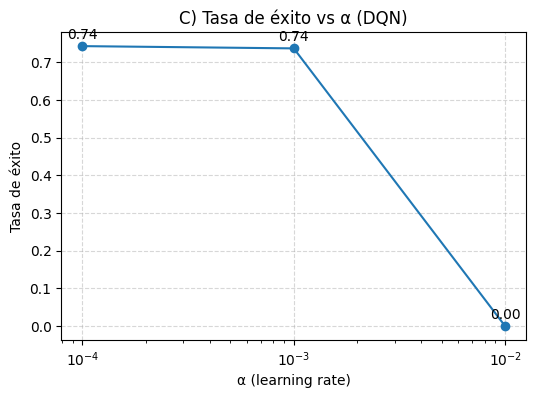

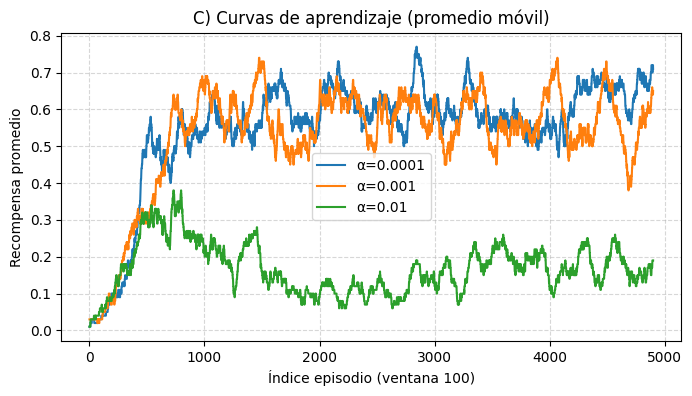

In [88]:
# prompt: Entrenar tres instancias de DQN con α = 0.0001, 0.001 y 0.01 (mismo número de episodios) y
# comparar sus tasas de éxito y recompensas medias para evaluar el efecto de α.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegúrarse de haber definido EPISODIOS_ENTRENO y EPISODIOS_EVAL
os.makedirs("resultados/C_variar_alpha", exist_ok=True)

alphas = [0.0001, 0.001, 0.01]   # bajo, medio, alto
resultados_C = []

for a in alphas:
    agente = DQNAgent(
        state_size=env.observation_space.n,
        action_size=env.action_space.n,
        lr=a,
        gamma=0.95,
        epsilon=1.0
    )
    # Entrenamiento y evaluación
    recomp = agente.entrenar(env, episodios=EPISODIOS_ENTRENO)
    tasa, _ = agente.evaluar(env, episodios=EPISODIOS_EVAL)

    # Guardamos en la lista
    resultados_C.append({
        'alpha': a,
        'tasa_exito': tasa,
        'recompensas': np.array(recomp)
    })

    # Volcar recompensas a CSV para cada alpha
    df_recomp = pd.DataFrame({
        'episodio': np.arange(len(recomp)),
        'recompensa': recomp
    })
    df_recomp.to_csv(f"resultados/C_variar_alpha/recompensas_alpha_{a}.csv", index=False)

# Resumen de tasas en CSV
dfC_tasas = pd.DataFrame([{'alpha': r['alpha'], 'tasa_exito': r['tasa_exito']}
                          for r in resultados_C])
dfC_tasas.to_csv("resultados/C_variar_alpha/tasas_alpha.csv", index=False)

# Gráfico: Tasa de éxito vs α
plt.figure(figsize=(6,4))
plt.plot(dfC_tasas['alpha'], dfC_tasas['tasa_exito'], marker='o')
plt.xscale('log')
plt.xlabel('α (learning rate)')
plt.ylabel('Tasa de éxito')
plt.title('C) Tasa de éxito vs α (DQN)')
plt.grid(True, linestyle='--', alpha=0.5)
for i,v in enumerate(dfC_tasas['tasa_exito']):
    plt.text(dfC_tasas['alpha'][i], v+0.02, f'{v:.2f}', ha='center')
plt.savefig("resultados/C_variar_alpha/tasa_vs_alpha.png", dpi=150, bbox_inches='tight')
plt.show()

# Gráfico: Curvas de aprendizaje suavizadas
def moving_average(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(8,4))
for r in resultados_C:
    ma = moving_average(r['recompensas'], 100)
    plt.plot(ma, label=f'α={r["alpha"]}')
plt.xlabel('Índice episodio (ventana 100)')
plt.ylabel('Recompensa promedio')
plt.title('C) Curvas de aprendizaje (promedio móvil)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("resultados/C_variar_alpha/curvas_alpha.png", dpi=150, bbox_inches='tight')
plt.show()



#**2) Cómo comparar e interpretar**

**Tabla de métricas**

In [89]:
rows = []
for r in resultados_C:
    rec = r['recompensas']
    rows.append({
        'alpha':     r['alpha'],
        'tasa_exito':r['tasa_exito'],
        'media_recomp': rec.mean(),
        'std_recomp':   rec.std()
    })
dfC_metrics = pd.DataFrame(rows).sort_values('alpha')
print(dfC_metrics)
dfC_metrics.to_csv('C_metrics_alpha.csv', index=False)

    alpha  tasa_exito  media_recomp  std_recomp
0  0.0001       0.743        0.5444    0.498025
1  0.0010       0.737        0.5238    0.499433
2  0.0100       0.000        0.1664    0.372439


**Comparacion de resultados**

**C) Comparación de resultados al variar α (learning rate) en DQN**

**Tasa de éxito vs. α**

α = 0.0001 → 74.3 % de éxitos.

α = 0.0010 → 73.7 % de éxitos (muy cercano a α=0.0001).

α = 0.0100 → 0 % de éxitos: el agente no aprende nada útil con un paso tan grande.


**Curvas de aprendizaje (promedio móvil 100)**

α = 0.0001 (azul): asciende rápidamente hasta ~0.65 y luego oscila sólidamente entre 0.55–0.75.

α = 0.0010 (naranja): comportamiento muy parecido, con subida rápida y estabilidad en torno a 0.5–0.7.

α = 0.0100 (verde): sube algo al inicio pero enseguida decae y se estanca cerca de 0.1–0.2, confirmando que pasos demasiado grandes impiden la convergencia.

#**Interpretacion**

Un learning rate muy alto (0.01) hace que la red actualice sus pesos de forma demasiado agresiva, provocando oscilaciones y divergencia: no logra aprender a llegar al objetivo.

Valores pequeños o moderados (1e-4, 1e-3) permiten al agente ajustar gradualmente sus estimaciones Q, obteniendo tasas de éxito ~74 % y recompensas medias superiores a 0.5, con variabilidad esperable por la naturaleza binaria de éxitos/fracaso.

#**Conclucion del punto C**

Para el DQN en el entorno FrozenLake, un α de 0.0001 o 0.001 resulta adecuado:

Ambos convergen rápido y mantienen una tasa de éxito alta (~74 %) con recompensas medias por episodio superiores a 0.5.

α = 0.001 aprende tan rápido como α = 0.0001 y mantiene estabilidad similar, por lo que es una buena opción por ser ligeramente más “ágil” en la fase inicial.

En cambio, un α demasiado alto (0.01) impide la convergencia, reduciendo la tasa de éxito a cero. Por lo tanto, para tu implementación final, te recomendamos usar α = 0.001 como balance entre velocidad de aprendizaje y estabilidad de la política